In [3]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using CUDA, BenchmarkTools
CUDA.allowscalar(false)

  Activating project at `~/cscs2023`


In [1]:
# work around a Jupyter bug
HTML("""
    <style>
        /*Disable code output line wrapping*/
        div.jp-RenderedText pre {
            white-space: pre;
        }
    </style>""")

HTML{String}("<style>\n    /*Disable code output line wrapping*/\n    div.jp-RenderedText pre {\n        white-space: pre;\n    }\n</style>")

# Application analysis and optimization

Accurately measuring execution time of GPU operations and its kernels is obviously important in order to optimize your application, but is complicated by the fact that GPU operations often run asynchronously, and on a different device (so Julia's existing tools generally don't work). In this notebook, I'll explain the different alternatives, and how to best use them.

## Time measurements

In Julia, we're used to using `@time`, `@elapsed`, and BenchmarkTools.jl for measuring the time it takes to execute some code. These tools can be used with code that performs GPU operations, but there's a caveat:

In [6]:
A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

# warmup
A * B

# measure time
@time A * B;

  0.000100 seconds (45 allocations: 1.109 KiB)


This seems much too fast. The problem with this measurement is that GPU operations are asynchronous, so we're really measuring the time to *submit* this operation, not the time it takes to complete it. To accurately measure execution time, we need to synchronize the GPU, i.e., wait for the device to finish executing:

In [7]:
# make sure the GPU is idle _before_ starting the measurement
synchronize()

@time begin
    A * B
    synchronize()
end

  0.056450 seconds (39.45 k allocations: 2.746 MiB, 98.72% compilation time)


A shorter version of this is wrapping your GPU-asynchronous code in `CUDA.@sync`:

In [8]:
synchronize()
@time CUDA.@sync A * B;

  0.000592 seconds (75 allocations: 3.438 KiB)


This is exactly what CUDA.jl's version of the `@time` macro does. In addition, it reports on GPU allocations; `Base.@time` only reports CPU allocations:

In [10]:
CUDA.@time A * B;

  0.000629 seconds (67 CPU allocations: 3.062 KiB) (1 GPU allocation: 4.000 MiB, 3.49% memmgmt time)


If you need to access these timings programmatically, you can use CUDA.jl's version of the `@timed` macro:

In [11]:
CUDA.@timed A * B

(value = Float32[258.50818 257.77057 … 251.55394 256.47467; 270.9783 273.4929 … 265.41052 266.9104; … ; 257.886 256.23856 … 248.41599 255.23917; 266.05188 270.8322 … 257.4447 261.8816], time = 0.000506202, cpu_bytes = 1312, cpu_gctime = 0.0, cpu_gcstats = Base.GC_Diff(1312, 0, 0, 47, 0, 0, 0, 0, 0), gpu_bytes = 4194304, gpu_memtime = 1.955900000000059e-5, gpu_memstats = (alloc_count = 1, alloc_bytes = 4194304, free_count = 0, free_bytes = 0, total_time = 1.955900000000059e-5))

For even simpler measurements, you can use `CUDA.@elapsed` behaving like `Base.@elapsed`. One minor difference to the other macros, is that it uses events to measure time and does not synchronize the entire stream, so it is a better mechanism when your application needs timings without disturbing the execution:

In [12]:
CUDA.@elapsed A * B

0.000485248f0

## Benchmarks

Most of the time, you shouldn't bother with these simple measurements and move on to BenchmarkTools.jl. The same rules apply -- make sure you synchronize the GPU so that actual execution time is measured:

In [13]:
A = CUDA.rand(Float32, 1024, 1024)
B = CUDA.rand(Float32, 1024, 1024)

@benchmark CUDA.@sync A * B

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  339.044 μs …   8.929 ms  ┊ GC (min … max): 0.00% … 14.56%
 Time  (median):     383.872 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   396.877 μs ± 120.976 μs  ┊ GC (mean ± σ):  0.06% ±  0.20%

                         ▁▅██▆▃▂▂▁▁▁▁                   ▁▄▆▅▃▁  ▂
  ▅▄▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄████████████▇▇█▇██▅▅▆▅▅▇▆▆▆▅▇▅▆███████ █
  339 μs        Histogram: log(frequency) by time        443 μs <

 Memory estimate: 1.11 KiB, allocs estimate: 45.

## Profiling

Similarly, because of the asynchronous CPU execution of GPU operations we cannot simply profile code:

In [14]:
using Profile
@profile CUDA.@sync A * B
Profile.print(; noisefloor=30.)

Overhead ╎ [+additional indent] Count File:Line; Function
  ╎6  @IJulia/src/eventloop.jl:38; (::IJulia.var"#15#18")()
 1╎1  @IJulia/src/heartbeat.jl:22; heartbeat_thread(sock::Ptr{Nothing})
  ╎32 ...rv/synchronization.jl:120; synchronization_worker(data::Ptr{...
Total snapshots: 41. Utilization: 22% across all threads and tasks. Use the `groupby` kwarg to break down by thread and/or task.


There isn't even a trace of the matrix multiplication in the profile output; all time is spent synchronizing! That means we'll need a GPU-specific profiler to visualize what's happening on the GPU, instead of analyzing the execution from the CPU side. Luckily, CUDA.jl has such a profiler built in:

In [15]:
CUDA.@profile A * B

Profiler ran for 14.59 ms, capturing 22 events.

Host-side activity: calling CUDA APIs took 128.03 µs (0.88% of the trace)
┌──────────┬────────────┬───────┬────────────────────────────────────┬──────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                  │ Name                     │
├──────────┼────────────┼───────┼────────────────────────────────────┼──────────────────────────┤
│    0.32% │   46.49 µs │     1 │                                    │ cudaLaunchKernel         │
│    0.23% │   33.62 µs │     1 │                                    │ cuMemAllocFromPoolAsync  │
│    0.20% │   28.61 µs │     1 │                                    │ cudaMemsetAsync          │
│    0.05% │    6.91 µs │     3 │    2.3 µs ± 2.35   (  0.72 ‥ 5.01) │ cudaStreamGetCaptureInfo │
│    0.02% │    3.58 µs │     1 │                                    │ cudaEventQuery           │
│    0.02% │    3.34 µs │     1 │                                    │ cudaEventRecord       

For more robust timings, use the `CUDA.@bprofile` macro, which combines `CUDA.@profile` with a benchmark harness (warming-up, running a couple of times, etc.):

In [16]:
CUDA.@bprofile A * B

Profiler ran for 1.0 s, capturing 56949 events.

Host-side activity: calling CUDA APIs took 930.96 ms (93.08% of the trace)
┌──────────┬────────────┬───────┬────────────────────────────────────────┬──────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                      │ Name                     │
├──────────┼────────────┼───────┼────────────────────────────────────────┼──────────────────────────┤
│   87.61% │  876.27 ms │  2476 │ 353.91 µs ± 26.55  ( 292.3 ‥ 430.35)   │ cuCtxSynchronize         │
│    1.62% │   16.24 ms │  2476 │   6.56 µs ± 1.2    (  5.72 ‥ 25.03)    │ cudaLaunchKernel         │
│    1.27% │   12.66 ms │  2476 │   5.11 µs ± 4.3    (  4.29 ‥ 212.43)   │ cuMemAllocFromPoolAsync  │
│    1.04% │   10.43 ms │  2476 │   4.21 µs ± 0.66   (  3.58 ‥ 16.69)    │ cudaMemsetAsync          │
│    0.35% │    3.46 ms │  2476 │    1.4 µs ± 0.48   (  0.95 ‥ 13.83)    │ cudaEventQuery           │
│    0.31% │    3.14 ms │  7428 │ 423.01 ns ± 221.33 (238.42

If you're instead interested in details about what the GPU is doing, you can pass `trace=true` to `CUDA.@profile` to disable summarization:

In [17]:
CUDA.@profile trace=true A * B

Profiler ran for 524.76 µs, capturing 22 events.

Host-side activity: calling CUDA APIs took 74.63 µs (14.22% of the trace)
┌────┬───────────┬───────────┬──────────────────────────┬──────────────────────────┐
│ ID │     Start │      Time │ Name                     │                  Details │
├────┼───────────┼───────────┼──────────────────────────┼──────────────────────────┤
│  5 │  16.45 µs │   18.6 µs │ cuMemAllocFromPoolAsync  │ 4.000 MiB, device memory │
│ 11 │  95.61 µs │   1.67 µs │ cudaGetDevice            │                        - │
│ 12 │  101.8 µs │   2.15 µs │ cudaStreamGetCaptureInfo │                        - │
│ 13 │ 104.43 µs │   3.81 µs │ cudaEventQuery           │                        - │
│ 14 │  109.2 µs │  16.21 µs │ cudaMemsetAsync          │                        - │
│ 15 │ 128.03 µs │  24.56 µs │ cudaLaunchKernel         │                        - │
│ 16 │ 153.06 µs │ 476.84 ns │ cudaGetLastError         │                        - │
│ 17 │ 154.02 µs │ 476.84 

## Case study: RMSE

As an example, let's go back to the implementation of RMSE using array operations:

In [24]:
rmse(A, B) = sqrt(sum((A-B).^2) / length(A))

A = CUDA.rand(2048, 2048)
B = CUDA.rand(2048, 2048)
CUDA.@bprofile rmse(A, B)

Profiler ran for 1.0 s, capturing 1170266 events.

Host-side activity: calling CUDA APIs took 443.38 ms (44.33% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                     │ Name                    │
├──────────┼────────────┼───────┼───────────────────────────────────────┼─────────────────────────┤
│    3.89% │   38.91 ms │  7464 │   5.21 µs ± 1.13   (  4.05 ‥ 23.37)   │ cuLaunchKernel          │
│    3.74% │   37.41 ms │  9967 │   3.75 µs ± 16.71  (  1.43 ‥ 501.87)  │ cuMemAllocFromPoolAsync │
│    3.04% │   30.43 ms │  2488 │  12.23 µs ± 1.56   ( 11.44 ‥ 41.01)   │ cuMemcpyDtoHAsync       │
│    2.16% │   21.59 ms │  2488 │   8.68 µs ± 67.2   (  6.44 ‥ 3317.36) │ cudaLaunchKernel        │
│    1.88% │   18.85 ms │  9900 │    1.9 µs ± 0.59   (  1.19 ‥ 18.6)    │ cuMemFreeAsync          │
│    0.80% │    7.97 ms │  4981 │    1.6 µs ± 0.63   (  0.95 ‥ 14.07)   │ 

Notice how many kernels we're launching. This is often suboptimal, as using multiple kernels for an operation that could have been implemented using a single kernel has several disadvantages:

- temporaries need to be allocated to pass data between kernels
- each kernel needs to read from global memory to fetch those temporaries
- the compiler can't optimize 'globally'

So let's try and fuse some operations together:

In [25]:
rmse(A, B) = sqrt(sum((A.-B).^2) / length(A))
CUDA.@bprofile rmse(A, B)

Profiler ran for 1.0 s, capturing 1178189 events.

Host-side activity: calling CUDA APIs took 438.13 ms (43.81% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                     │ Name                    │
├──────────┼────────────┼───────┼───────────────────────────────────────┼─────────────────────────┤
│    5.49% │   54.91 ms │  9300 │    5.9 µs ± 8.01   (  3.81 ‥ 544.55)  │ cuLaunchKernel          │
│    3.92% │    39.2 ms │  9309 │   4.21 µs ± 22.71  (  1.43 ‥ 1778.13) │ cuMemAllocFromPoolAsync │
│    3.75% │   37.51 ms │  3100 │   12.1 µs ± 1.31   ( 11.21 ‥ 32.66)   │ cuMemcpyDtoHAsync       │
│    1.71% │   17.08 ms │  8919 │   1.91 µs ± 0.56   (  1.19 ‥ 15.02)   │ cuMemFreeAsync          │
│    0.98% │    9.82 ms │  6203 │   1.58 µs ± 0.72   (  0.95 ‥ 14.78)   │ cuStreamSynchronize     │
│    0.68% │     6.8 ms │  3106 │   2.19 µs ± 0.66   (  1.67 ‥ 19.31)   │ 

So around a 15% performance improvement! In fact, fusing kernels like this is a very important optimization technique on the GPU, not only because it avoids having to launch additional kernels, but also because it avoids having to store intermediate results in memory.

But we can go further. For example, we can fuse the broadcast into the reduction by passing an unmaterialized broadcast:

In [26]:
function rmse(A, B)
    bc = Base.broadcasted(A, B) do a, b
        (a - b) ^ 2
    end
    sqrt(sum(bc) / length(A))
end
CUDA.@bprofile rmse(A, B)

Profiler ran for 1.0 s, capturing 1267988 events.

Host-side activity: calling CUDA APIs took 463.32 ms (46.33% of the trace)
┌──────────┬────────────┬───────┬──────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                    │ Name                    │
├──────────┼────────────┼───────┼──────────────────────────────────────┼─────────────────────────┤
│    5.59% │   55.89 ms │  4669 │  11.97 µs ± 1.47   ( 11.21 ‥ 36.0)   │ cuMemcpyDtoHAsync       │
│    5.57% │   55.68 ms │  9338 │   5.96 µs ± 5.48   (  4.05 ‥ 508.07) │ cuLaunchKernel          │
│    2.96% │   29.57 ms │  9338 │   3.17 µs ± 1.69   (  1.43 ‥ 89.88)  │ cuMemAllocFromPoolAsync │
│    1.44% │   14.43 ms │  9338 │   1.54 µs ± 0.71   (  0.95 ‥ 14.07)  │ cuStreamSynchronize     │
│    0.96% │    9.64 ms │  4669 │   2.07 µs ± 0.63   (  1.67 ‥ 14.07)  │ cuCtxSynchronize        │
└──────────┴────────────┴───────┴──────────────────────────────────────┴──────────

### External profilers

Going beyond the integrated profiler NVIDIA has some great tools for profiling GPU code, bundled under the NVIDIA Nsight suite. There are several tools, one for each type of GPU application, and these replace the old monolithic profiler (`nvprof` and `nvvp`) which are now deprecated:

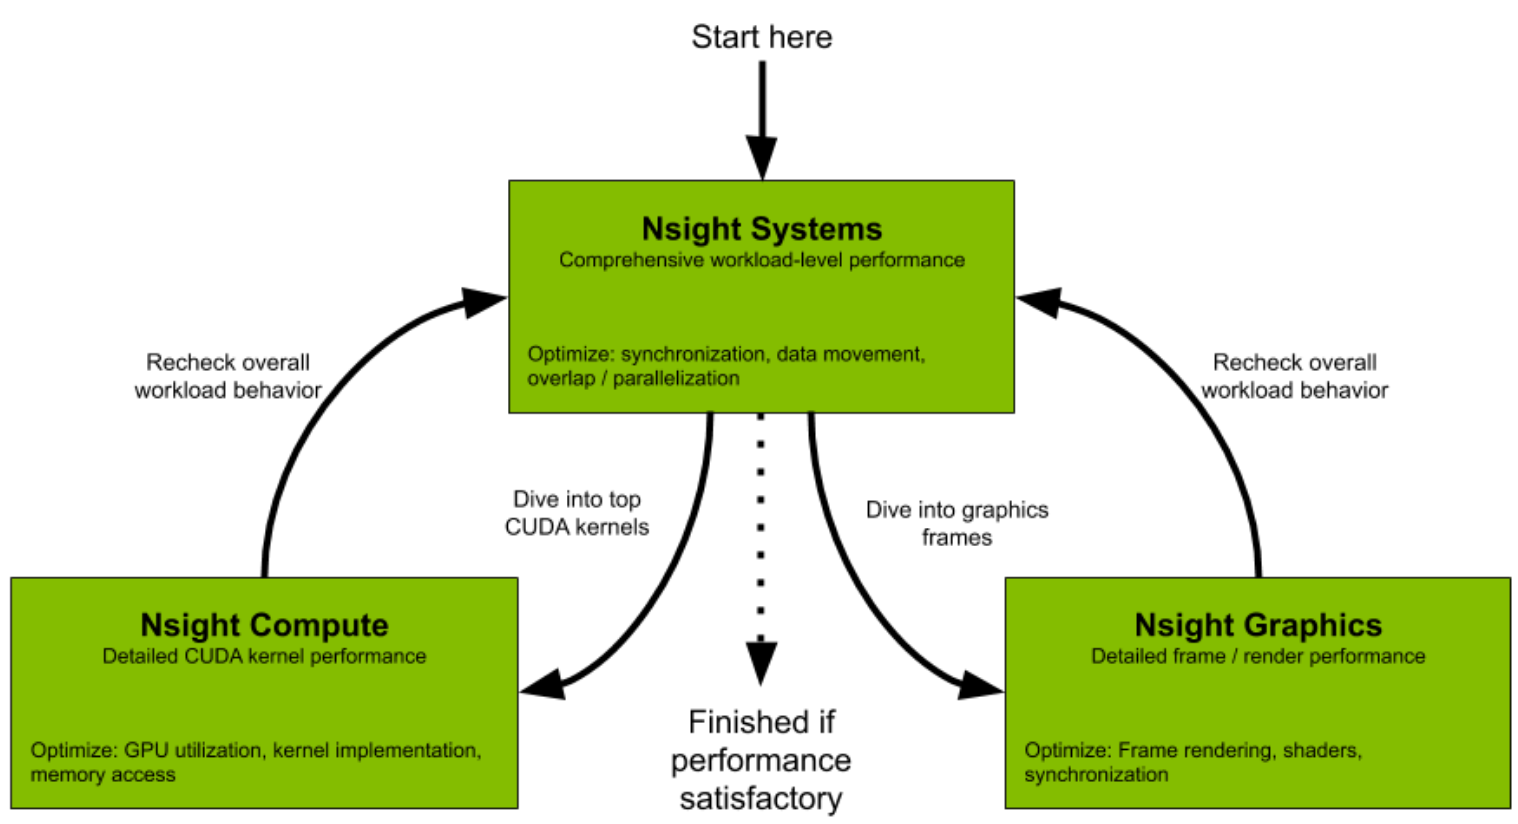

Due to the significant compilation times with Julia/CUDA.jl, and/or the possibility to work with the GPU interactively (e.g. from the REPL or a Jupyter notebook), it is recommended to use external tools in a mode where they only collect data when requested. Doing so can also be done using the `CUDA.@profile` macro, passing `external=true`:

```
CUDA.@profile external=true your_code()
```

## NVIDIA Nsight Systems

The first NSight tool you should probably use to profile a GPU application, is NSight Systems. This tool gives an application-level overview, including a handy timeline, quickly visualizing times during execution where the GPU is underutilized and which operations are to blame for that.

The tool has two modes of operation:
- profile: run an application and profile it
- launch: launch an application for interactive profiling

There are also two ways of running the profiler:
- using the `nsys` binary on one end, and `nsys-ui` to visualize the result
- using `nsys-ui` to set-up and launch `nsys` automatically

For this course, we'll be doing the latter:

- on the cluster: run under NSight Systems CLI from a separate Jupyter terminal
- on your host: [download](https://developer.nvidia.com/nsight-systems) and install NSight Systems to visualize traces

Because of some peculiarities with this cluster, I've provided a script to launch Julia under NSight Systems and generate reports in the `scratch` folder of your home directory:

```
$ cd cscs2023
$ ./julia_nsys
julia> using CUDA
```

Now, you should be able to generate reports for a kernel:

```
julia> CuArray([1]) .+ 1   # warm-up

julia> CUDA.@profile external=true CUDA.@sync CuArray([1]).+1

WARNING: CUDA tracing is required for cudaProfilerStart/Stop API support. Turning it on by default.
Capture range started in the application.
Capture range ended in the application.
Generating '/tmp/nsys-report-7ecc.qdstrm'
[1/1] [========================100%] report1.nsys-rep
Generated:
    /scratch/snx3000/julia/tbesard/report1.nsys-rep
```

You can now download this report from the Jupyter file browser and open it locally using the NSight Systems UI. At first, this will reveal a very sparse timeline:

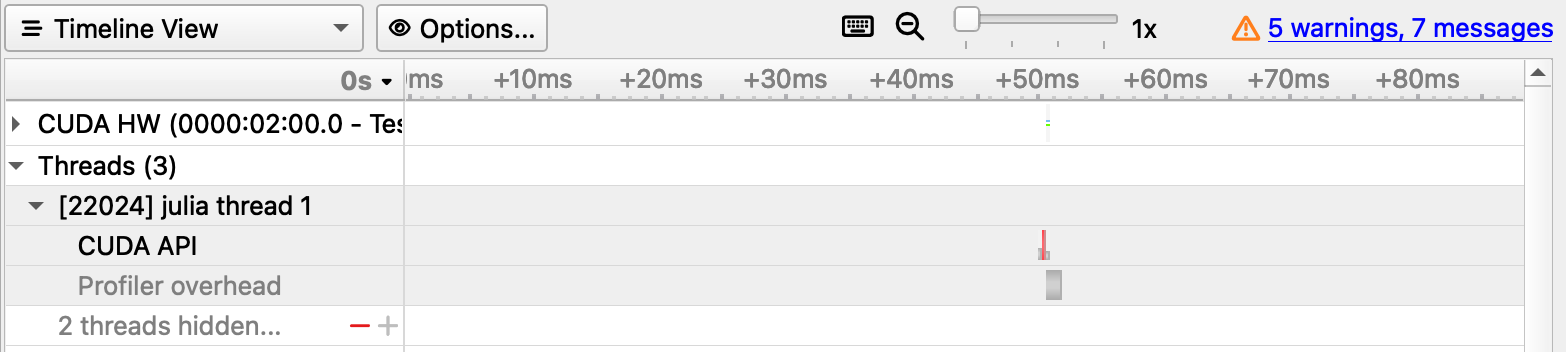

By selecting a part of the timeline using the mouse, and using the right-click context menu to Zoom into Selection, we can reveal the interesting bits:

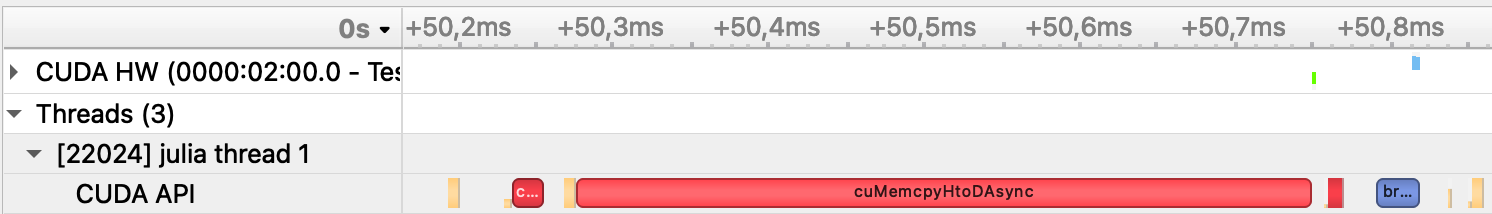

For the record, it's also possible to run Jupyter under NSight Systems, by adding a kernel definition like the following:

```
{
  "display_name": "Julia (under NSight Systems)",
  "argv": [
    "/usr/local/bin/nsys",
    "launch",
    "/path/to/bin/julia",
    "-i",
    "--color=yes",
    "--project=@.",
    "/home/tim/Julia/depot/packages/IJulia/e8kqU/src/kernel.jl",
    "{connection_file}"
  ],
  "language": "julia",
  "env": {},
  "interrupt_mode": "signal"
}
```

Although this greatly simplifies the workflow, it's not practical to deploy on a cluster like this one.

Let's profile our RMSE implementations now:

In [4]:
slow_rmse(A, B) = sqrt(sum((A-B).^2) / length(A))

A = CUDA.rand(2048, 2048)
B = CUDA.rand(2048, 2048)

# warmup
slow_rmse(A, B)

CUDA.@profile external=true slow_rmse(A, B)

0.40833974f0

<div class="alert alert-block alert-info">
    <strong>Note</strong>: We don't need to use <code>CUDA.@sync</code> here, because we're reducing to a scalar, which requires waiting for the device to finish computing.
</div>

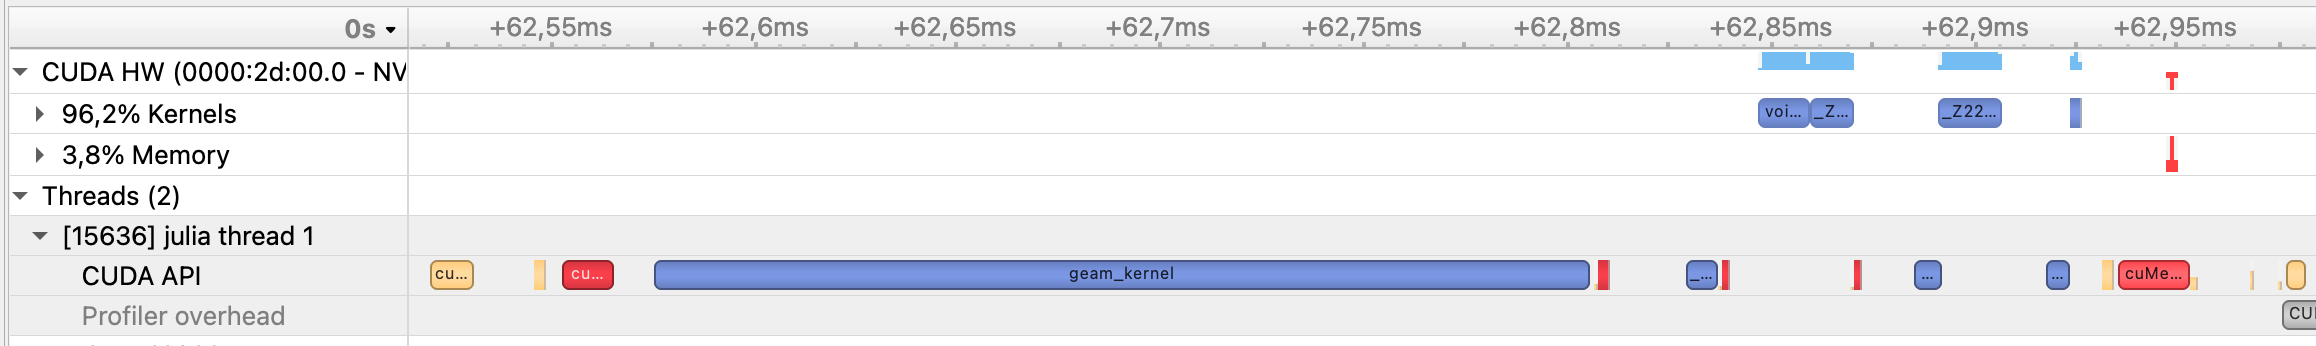

In [6]:
function fast_rmse(A, B)
    bc = Base.broadcasted(A, B) do a, b
        (a - b) ^ 2
    end
    bc = Broadcast.instantiate(bc)
    sqrt(sum(bc) / length(A))
end

# warmup
fast_rmse(A, B)

CUDA.@profile external=true fast_rmse(A, B)

0.40813175f0

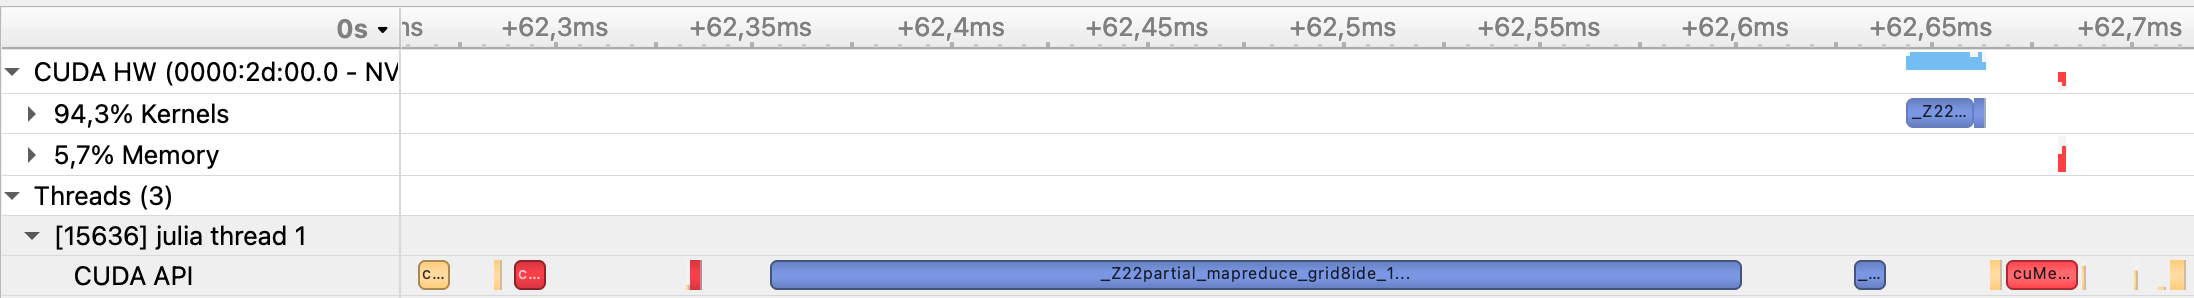

Even with this "fast" implementation, we can see that the GPU is severely underutilized! We'll address that later in this notebook.

For details on the kernel's execution, expand the `GPU` part of the timeline and hover the kernel in question:

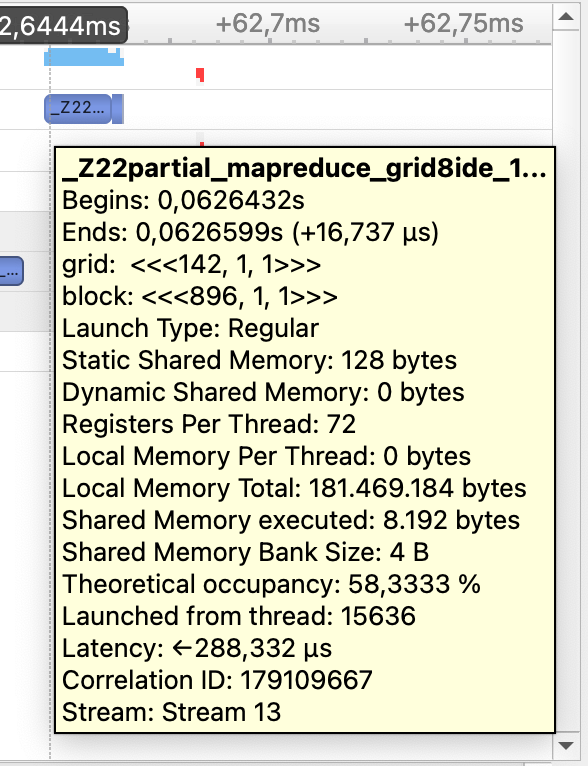

That gives some useful information on the kernel, but generally, there's more low-hanging fruit at the application level rather than at individual kernels. However, it give some initial insights without having to resort to NSight Compute.

### NVIDIA Tools Extensions

To accurately measure the total time it takes to execute this operation, you can use the mouse to measure on the timeline. A better approach is to denote the operation in source code, using NVIDIA's Tools Extensions (NVTX) library. This will then be picked up by NSight Systems, and added to the timeline:

In [9]:
using NVTX
CUDA.@profile external=true NVTX.@range "RMSE" fast_rmse(A, B)

0.40813175f0

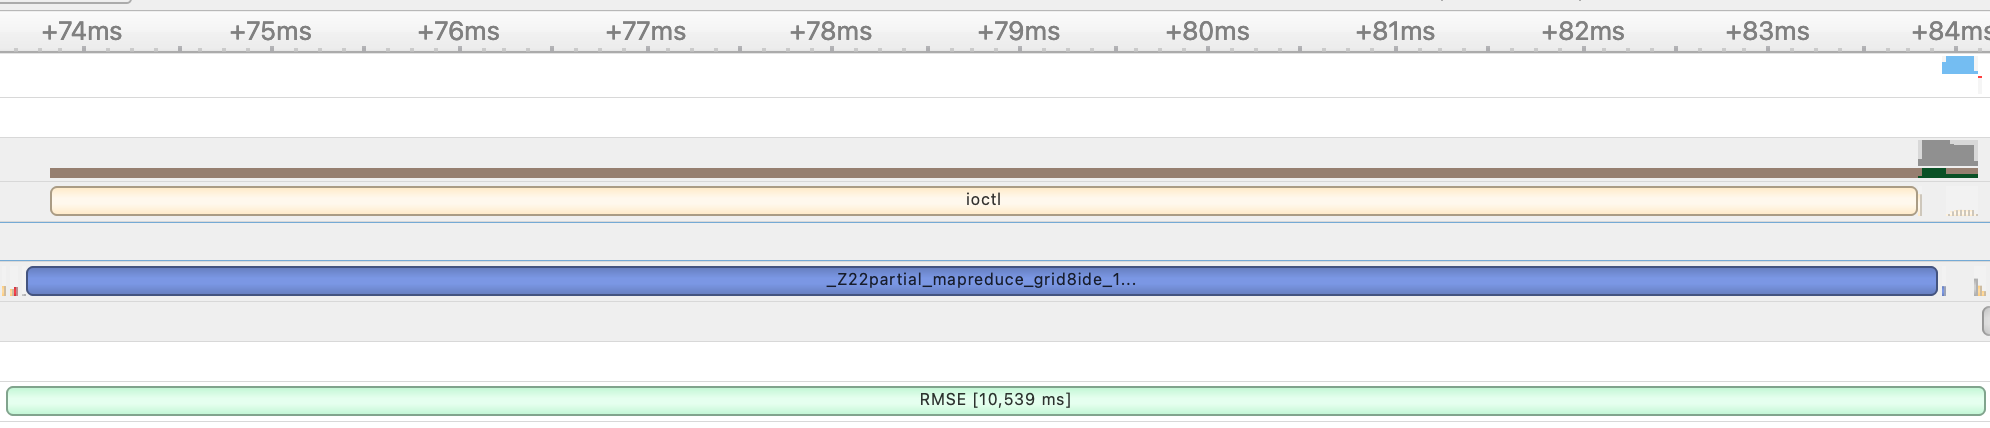

Note how our NVTX range nicely includes the time it took to queue the operation, as well as the execution on the GPU. This requires the NVTX range to include a synchronization!

The initial API call here is suspiciously slow though. This is a common occurence, and therefore it's recommended to profile any short-running application twice:

In [10]:
CUDA.@profile external=true begin
    NVTX.@range "RMSE 1" fast_rmse(A, B)
    NVTX.@range "RMSE 2" fast_rmse(A, B)
end

0.40813175f0

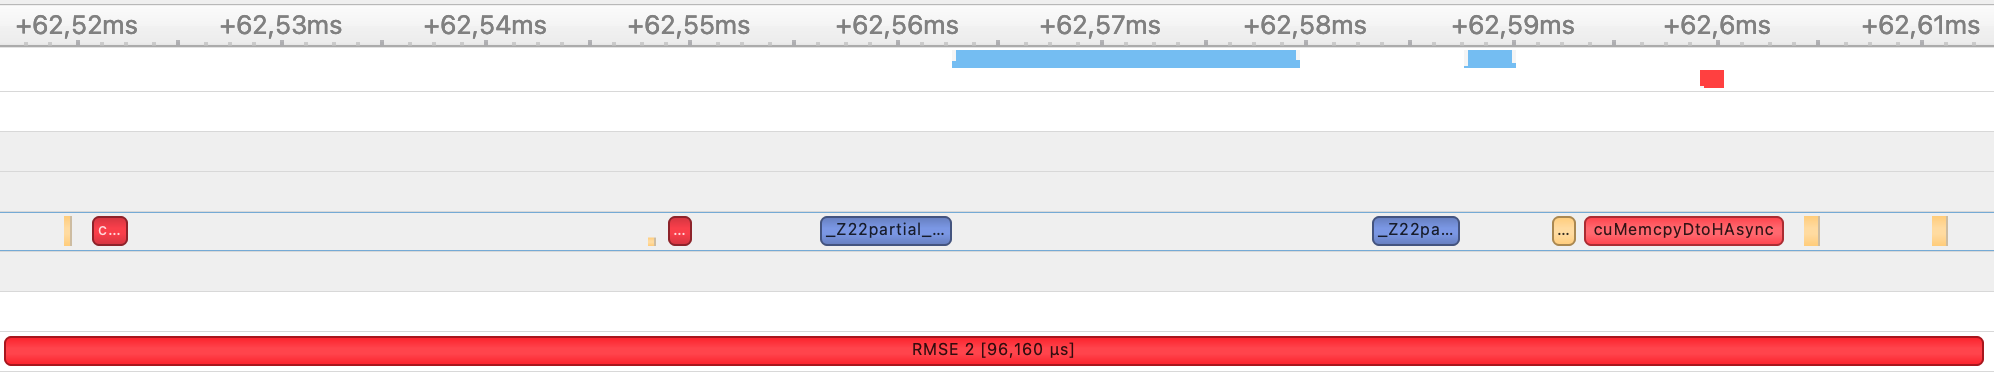

That's better, and much closer to our earlier benchmark results. Notice that it is still slightly slower, and some overhead is to be expected when running under the profiler.

A more convenient way to use NVTX is to stick it in front of a function definition:

In [11]:
NVTX.@annotate function rmse(A, B)
    bc = Base.broadcasted(A, B) do a, b
        (a - b) ^ 2
    end
    bc = Broadcast.instantiate(bc)
    sqrt(sum(bc) / length(A))
end

CUDA.@profile external=true begin
    rmse(A, B)
    rmse(A, B)
end

0.40813175f0

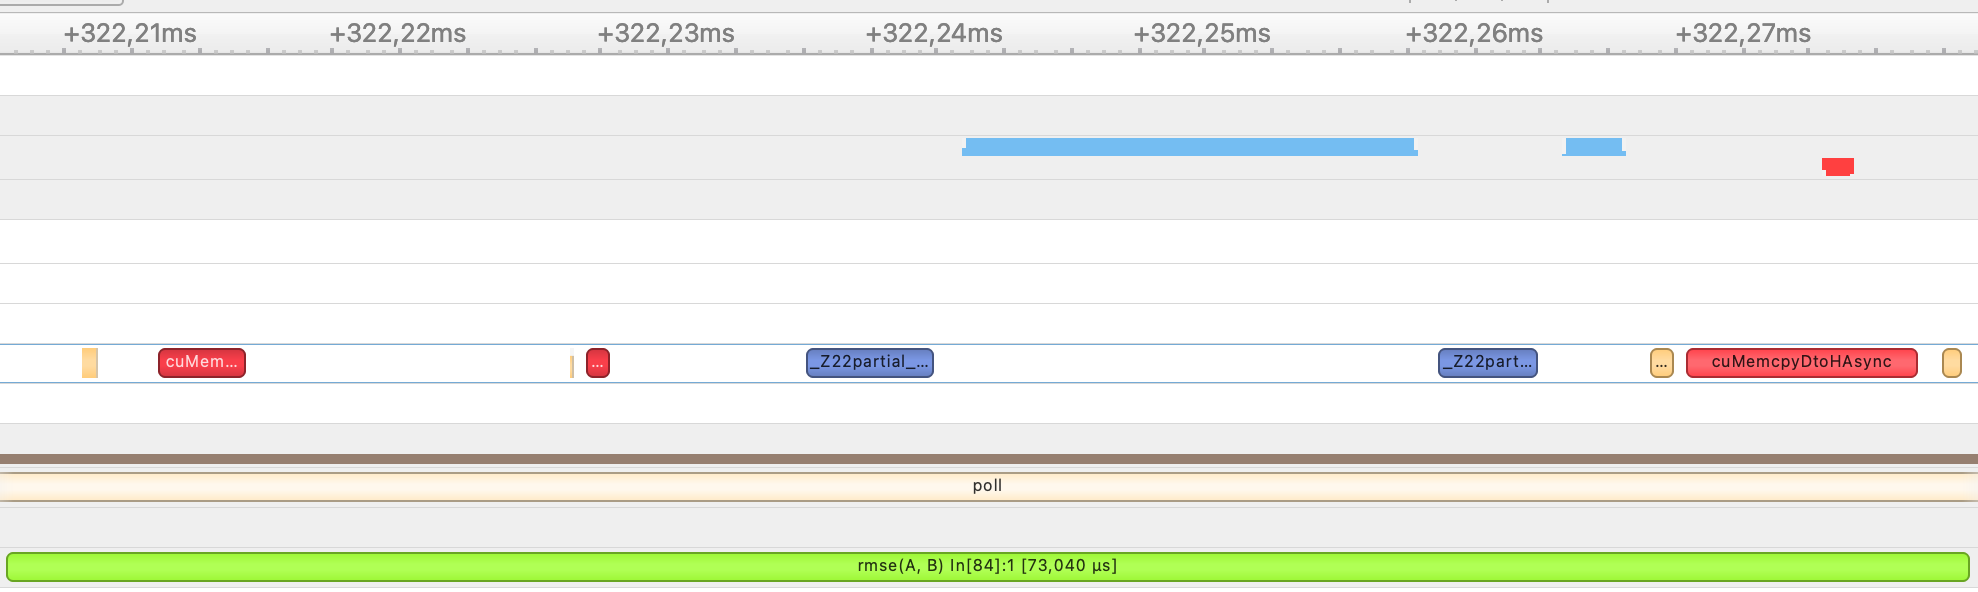

## Case study: Batched RMSE

As noted above, our RMSE implementation doesn't use the GPU efficiently because there simply isn't enough work. So, as a case study, let's increase the amount of work by computing the RMSE of many inputs:

In [16]:
N = 16
A = CUDA.rand(2048, 2048, N);
B = CUDA.rand(2048, 2048, N);

An initial approach may be to loop over the batch dimension and compute the RMSE for each input separately:

In [17]:
NVTX.@annotate function rmse(A, B)
    bc = Base.broadcasted(A, B) do a, b
        (a - b) ^ 2
    end
    bc = Broadcast.instantiate(bc)
    sqrt(sum(bc) / length(A))
end

NVTX.@annotate function doit()
    rmses = Vector{eltype(A)}(undef, N)
    for i in 1:N
        rmses[i] = rmse(A[:, :, i], B[:, :, i])
    end
    rmses
end

@benchmark doit()

BenchmarkTools.Trial: 544 samples with 1 evaluation.
 Range (min … max):  8.967 ms …  14.617 ms  ┊ GC (min … max): 0.00% … 6.26%
 Time  (median):     9.018 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.196 ms ± 960.673 μs  ┊ GC (mean ± σ):  0.36% ± 1.23%

  █                                                            
  ██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇ ▆
  8.97 ms      Histogram: log(frequency) by time      14.4 ms <

 Memory estimate: 126.91 KiB, allocs estimate: 2562.

To determine whether we're using the GPU efficiently, let's look at a timeline:

In [19]:
CUDA.@profile external=true (doit(); doit());

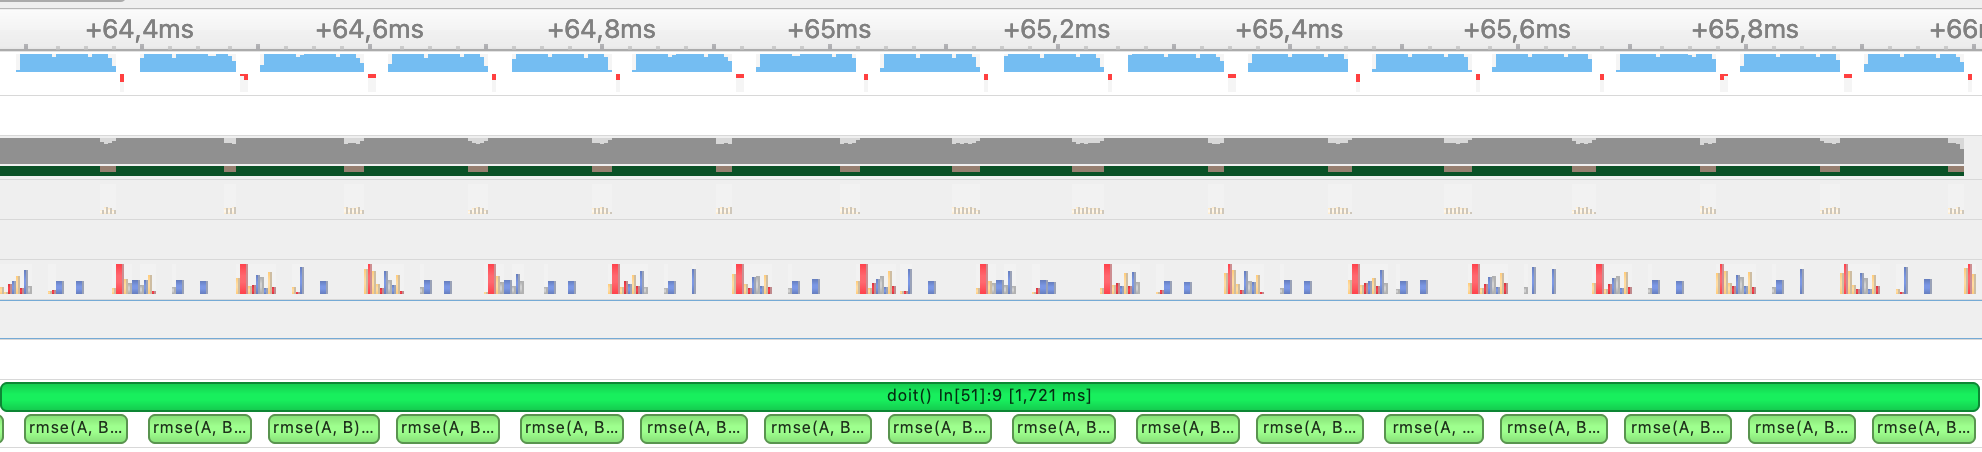

What we're generally looking for, is a continuous stream of kernels that keeps the GPU busy. That's not the case here, as there's lots of white space between blocks of kernels indicating the GPU is essentially idle at that time. This is generally caused by the CPU not being able to queue work quickly enough, so we need to avoid needless operations (memory allocations, copies, or just CPU operations in general) between launching subsequent kernels.

Given the guidelines and tools explained before, try to analyze and optimize this batched implementation. Focus on optimizing the application from the high level, we'll separately deal with optimizing a kernel in the next notebook.

### Avoid unnecessary allocations and copies

If we look at the trace of our `doit` function, we can see that the individual `rmse` invocations aren't package together, and some time is being wasted before every iteration:

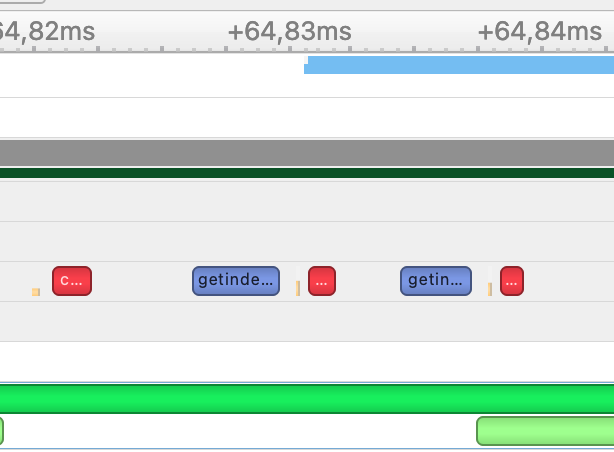

Because of how we are slicing arrays, we are allocating temporary containers and copying data around! This isn't necessary here, because we don't mutate the input data, so let's use views instead:

In [18]:
NVTX.@annotate function doit()
    rmses = Vector{eltype(A)}(undef, N)
    for i in 1:N
        rmses[i] = rmse(view(A, :, :, i), view(B, :, :, i))
    end
    rmses
end

@benchmark doit()

BenchmarkTools.Trial: 1695 samples with 1 evaluation.
 Range (min … max):  2.826 ms … 55.745 ms  ┊ GC (min … max): 0.00% … 28.90%
 Time  (median):     2.851 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.944 ms ±  2.126 ms  ┊ GC (mean ± σ):  0.87% ±  1.14%

             ▂▄▄▇▆▇█▆▆▆▇▂▄▃▃▁▂▁▁  ▁                           
  ▂▂▂▂▃▃▅▄▅▅▆██████████████████████▇█▆▆▆▅▇▆▅▅▄▅▄▄▄▃▃▃▃▂▂▁▁▁▃ ▅
  2.83 ms        Histogram: frequency by time        2.89 ms <

 Memory estimate: 78.16 KiB, allocs estimate: 1458.

We can do so a little more succinctly using the `@views` macro:

In [20]:
NVTX.@annotate function doit()
    rmses = Vector{eltype(A)}(undef, N)
    for i in 1:N
        rmses[i] = @views rmse(A[:, :, i], B[:, :, i])
    end
    rmses
end

doit (generic function with 1 method)

In [22]:
CUDA.@profile external=true (doit(); doit());

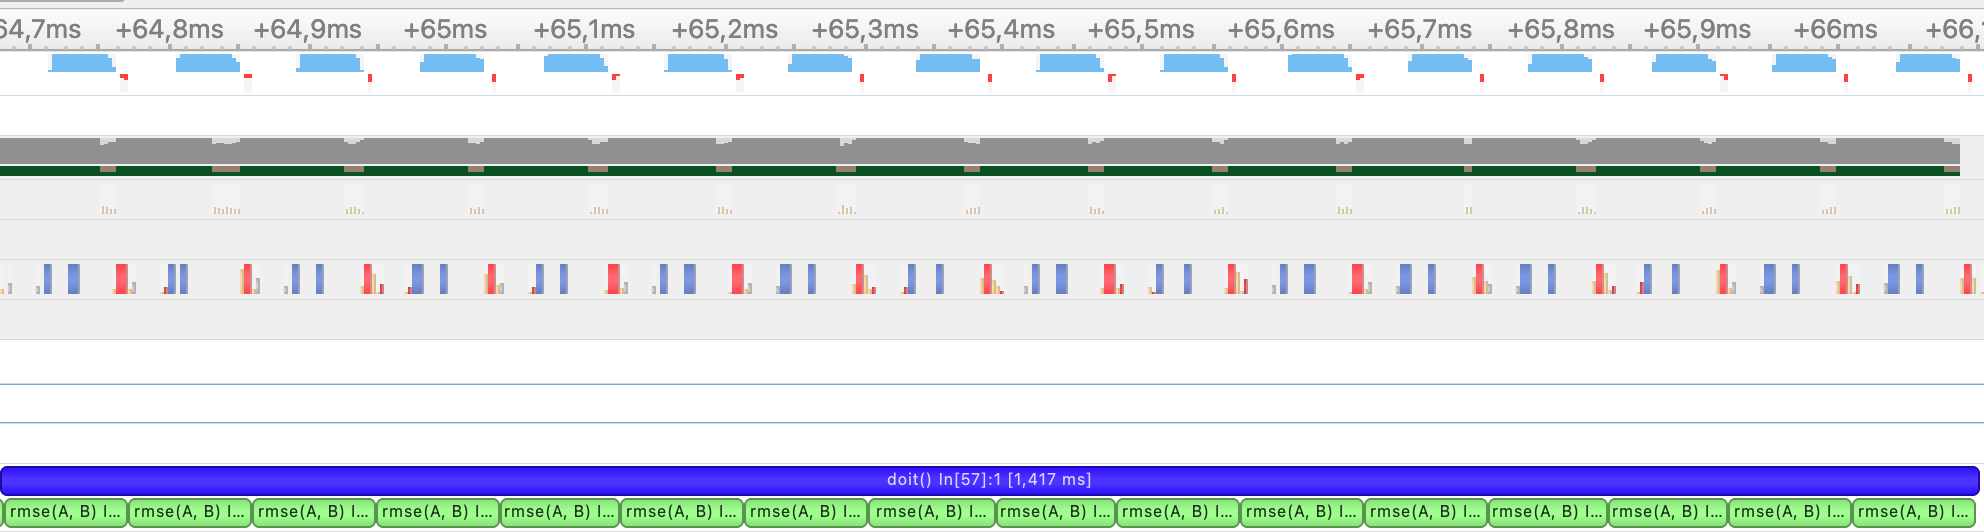

The invocations of the `rmse` function are now closely packed together, but the GPU trace itself is still sparse. There are several reasons for this:

- lots of kernels are being launched: this takes time, and requires temporary allocations
- each iteration waits for the GPU to finish, as we compute a scalar sum

### Avoid synchronization

A good first trick is to always reduce to an array, which doesn't need to be available immediately, as opposed to the scalar value we are currently reducing to:

In [10]:
NVTX.@annotate function rmse(A, B)
    bc = Base.broadcasted(A, B) do a, b
        (a - b) ^ 2
    end
    bc = Broadcast.instantiate(bc)
    sqrt.(sum(bc; dims=(1,2)) ./ length(A))
end

NVTX.@annotate function doit()
    rmses = Vector(undef, N)
    for i in 1:N
        rmses[i] = @views rmse(A[:, :, i], B[:, :, i])
    end
    vcat(Array.(rmses)...)
end

@benchmark doit()

BenchmarkTools.Trial: 1849 samples with 1 evaluation.
 Range (min … max):  2.570 ms … 54.743 ms  ┊ GC (min … max): 0.00% … 25.51%
 Time  (median):     2.580 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.696 ms ±  2.366 ms  ┊ GC (mean ± σ):  1.16% ±  1.26%

        ▄█▇▆▁                                                 
  ▂▂▂▂▅▇█████▆▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▃▃▃▃▂▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂ ▃
  2.57 ms        Histogram: frequency by time        2.63 ms <

 Memory estimate: 104.09 KiB, allocs estimate: 1904.

In [27]:
CUDA.@profile external=true (doit(); doit());

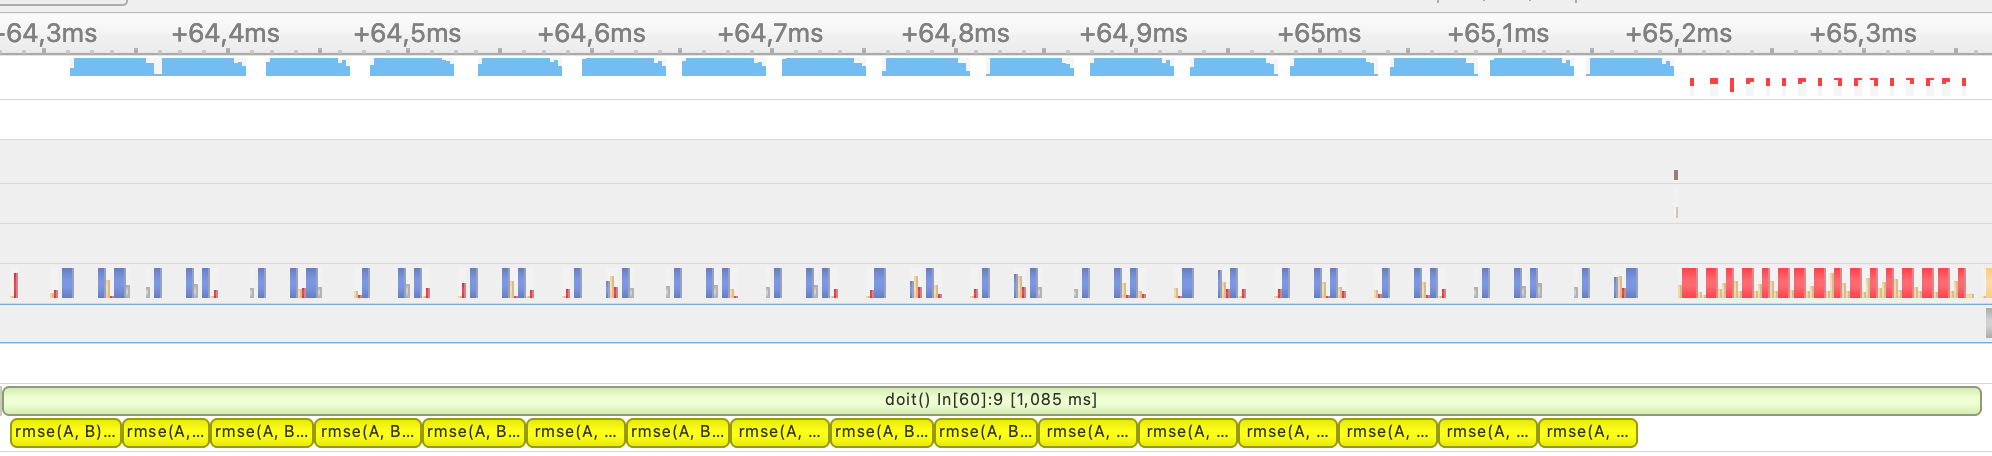

With all synchronizing operations now happening at the end, the gaps in the GPU trace have reduced, but aren't gone completely. This is because we're still doing too much work between kernel launches, e.g., allocating the output `C` array. We can avoid this by pre-allocating the output:

In [28]:
NVTX.@annotate function rmse!(C, A, B)
    bc = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    bc = Broadcast.instantiate(bc)
    # sum! doesn't support broadcasted inputs :-(
    #sum!(C, bc)
    Base.mapreducedim!(identity, +, C, bc)
    C .= sqrt.(C./length(A))
    return
end

NVTX.@annotate function doit()
    rmses = similar(A, N)
    fill!(rmses, zero(eltype(A)))
    for i in 1:N
        @views rmse!(reshape(rmses[i], 1, 1), A[:, :, i], B[:, :, i])
    end
    Array(rmses)
end

doit()

16-element Vector{Float32}:
 0.40825745
 0.40836805
 0.4082609
 0.40839142
 0.40804696
 0.4083096
 0.40830582
 0.4084182
 0.408449
 0.40838233
 0.40822595
 0.40812433
 0.40823087
 0.40827617
 0.40838924
 0.40826455

In [29]:
@benchmark doit()

BenchmarkTools.Trial: 1943 samples with 1 evaluation.
 Range (min … max):  2.468 ms … 36.202 ms  ┊ GC (min … max): 0.00% … 41.06%
 Time  (median):     2.492 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.543 ms ±  1.308 ms  ┊ GC (mean ± σ):  0.86% ±  1.56%

                       ▁▂▆█▇▅▆▁                               
  ▂▂▂▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▄▅▇████████▇▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂ ▃
  2.47 ms        Histogram: frequency by time        2.52 ms <

 Memory estimate: 105.92 KiB, allocs estimate: 1914.

In [30]:
CUDA.@profile external=true (doit(); doit());

We are now performing way fewer memory operations, both at every iteration and at the end of the execution:

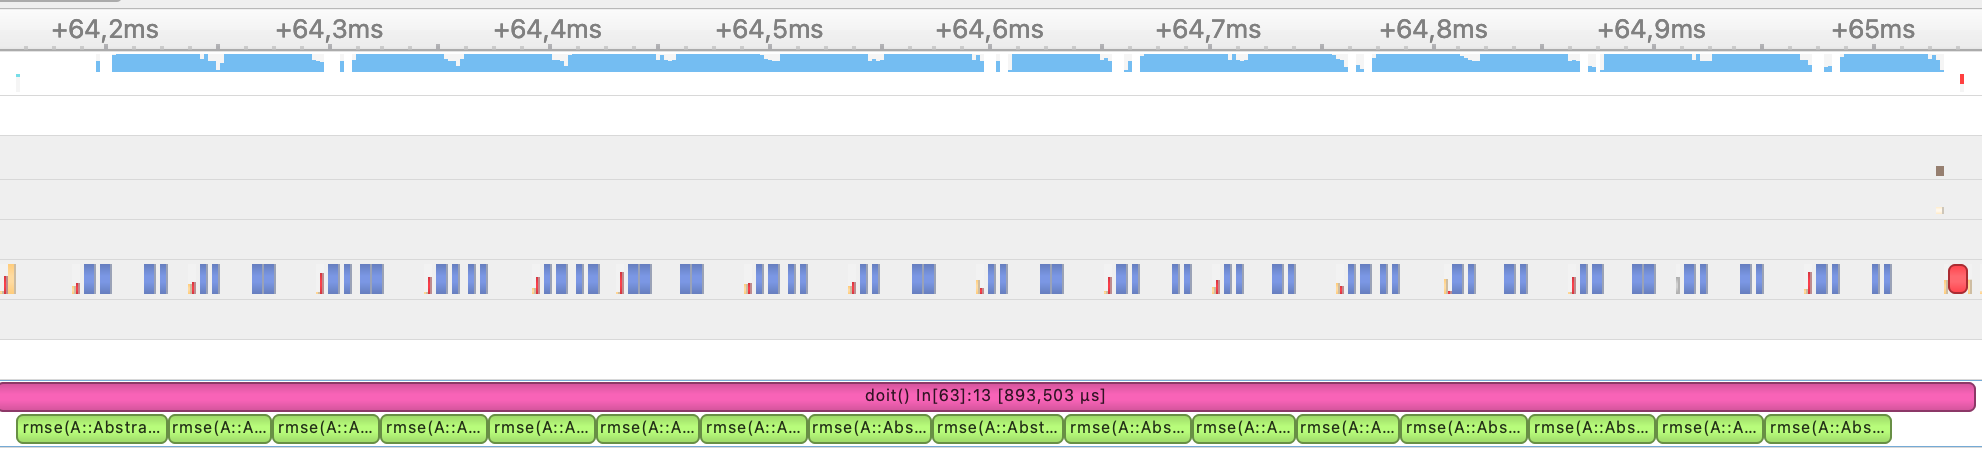

### Fusing the loop

We already fused the inner operations together as much as possible to avoid the cost of launching multiple kernels, but in fact, we do much more and fuse the entire loop together:

In [31]:
NVTX.@annotate function rmse!(C, A, B)
    bc = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    bc = Broadcast.instantiate(bc)
    Base.mapreducedim!(identity, +, C, bc)
    C .= sqrt.(C ./ prod(size(A)[1:2]))
    return
end

NVTX.@annotate function doit()
    rmses = similar(A, 1, 1, N)
    fill!(rmses, zero(eltype(A)))
    rmse!(rmses, A, B)
    Array(rmses)
end

doit()

1×1×16 Array{Float32, 3}:
[:, :, 1] =
 0.40825745

[:, :, 2] =
 0.40836802

[:, :, 3] =
 0.4082609

;;; … 

[:, :, 14] =
 0.40827617

[:, :, 15] =
 0.40838924

[:, :, 16] =
 0.40826455

In [32]:
@benchmark doit()

BenchmarkTools.Trial: 1380 samples with 1 evaluation.
 Range (min … max):  3.583 ms … 3.786 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.608 ms             ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.609 ms ± 9.880 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▁▂             ▃▅▇███▇▆▅▃▃▂                        ▁
  ▆▄▆▄████████▆▄▅▄▁▄▄▅▅███████████████▇██▇██▇███▆▆▇▄▅▇▄▇▁▅▆ █
  3.58 ms     Histogram: log(frequency) by time     3.64 ms <

 Memory estimate: 7.36 KiB, allocs estimate: 117.

In [33]:
CUDA.@profile external=true (doit(); doit());

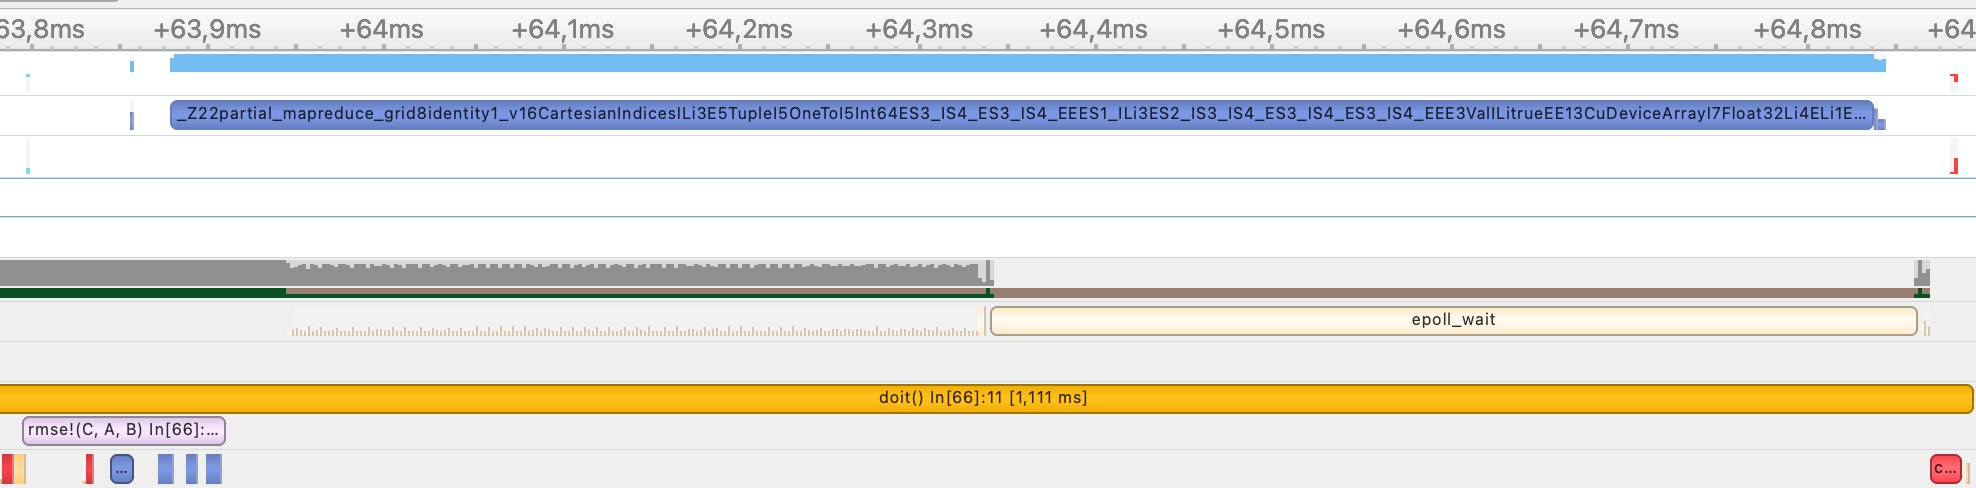

By getting rid of the loop, we only need to launch a single series of (more complicated) kernels. As it turns out, that causes performance to drop! This is surprising, and is likely caused by the added complexity causing occupancy to drop below a certain threshold. More on that during the kernel optimization notebook.

### Summary

In summary, when optimizing a GPU application it's good to:

- fuse operations: avoids temporaries, reduces launch overhead, and enables global optimization
- avoid synchronization: either explicit, or implicit (e.g. using pinned memory)
- bundle memory operations: pre-allocation, fetch results at the end

At any point, use the available tools to measure and analyze the performance of your application:

- `CUDA.@time`, `CUDA.@elapsed` for simple measurements
- `BenchmarkTools.@benchmark` with `CUDA.@sync` for more robust measurements
- `CUDA.@profile` for high-level insights (e.g., to find slow operations)
- NSight Systems for more detailed application analysis (e.g., to spot stalls)

Many of these optimization can be implemented generically, i.e., without introducing GPU-specific operations (e.g. avoiding calls to constructors but use `similar`, ...). As a result, it's still possible to use the above functions with CPU arrays, even with the NVTX annotations still attached to them:

In [34]:
A = rand(Float32, 2048, 2048, N)
B = rand(Float32, 2048, 2048, N)

NVTX.@range function rmse!(C, A, B)
    bc = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    bc = Broadcast.instantiate(bc)
    # Base's mapreducedim! doesn't support broadcasted inputs :-(
    bc = Broadcast.materialize(bc)
    Base.mapreducedim!(identity, +, C, bc)
    C .= sqrt.(C ./ prod(size(A)[1:2]))
    return
end

NVTX.@range function doit()
    rmses = similar(A, 1, 1, N)
    fill!(rmses, zero(eltype(A)))
    rmse!(rmses, A, B)
    Array(rmses)
end

doit()

1×1×16 Array{Float32, 3}:
[:, :, 1] =
 0.40814298

[:, :, 2] =
 0.4082902

[:, :, 3] =
 0.40827003

;;; … 

[:, :, 14] =
 0.40840867

[:, :, 15] =
 0.4083168

[:, :, 16] =
 0.40836045

In [36]:
@benchmark doit()

BenchmarkTools.Trial: 32 samples with 1 evaluation.
 Range (min … max):  150.538 ms … 165.658 ms  ┊ GC (min … max): 0.00% … 8.71%
 Time  (median):     155.016 ms               ┊ GC (median):    2.47%
 Time  (mean ± σ):   157.802 ms ±   7.188 ms  ┊ GC (mean ± σ):  4.43% ± 4.36%

  █▄                                                        ▆▄   
  ██▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▆ ▁
  151 ms           Histogram: frequency by time          166 ms <

 Memory estimate: 256.00 MiB, allocs estimate: 4.